In [2]:
from utils import load_cnf, cnf_to_bqm
from embedding_utils import *
import seaborn as sns
from redundancy import *
from utils import *

In [3]:
def get_distance(sample1, sample2):
    distance = 0
    for (key, value) in sample1.items():
        if value != sample2[key]:
            distance+=1
    return distance

In [4]:
folder = 'sat'
_variables = 180
path = f"./{folder}/sgen1-{folder}-{_variables}-100.cnf"

In [5]:
num_variables, num_clauses, variables, clauses = load_cnf(path)
bqm, or_result_vars, clauses_qubits, temp = cnf_to_bqm(variables, clauses)

In [6]:
cnf_result = "-1 -2 3 -4 -5 6 -7 -8 -9 -10 -11 12 -13 -14 -15 -16 -17 18 -19 -20 -21 -22 23 -24 -25 -26 27 -28 -29 -30 -31 32 -33 -34 -35 36 -37 -38 -39 -40 41 -42 -43 -44 -45 -46 -47 -48 49 -50 51 -52 -53 -54 -55 -56 -57 -58 59 -60 61 -62 -63 -64 -65 -66 -67 68 -69 -70 71 -72 -73 -74 -75 -76 -77 78 -79 -80 -81 -82 -83 84 -85 -86 87 -88 -89 -90 -91 -92 -93 94 -95 -96 -97 -98 99 -100 -101 -102 -103 104 -105 -106 107 -108 -109 -110 -111 -112 113 -114 -115 116 -117 -118 -119 -120 -121 -122 -123 124 -125 -126 -127 128 -129 -130 -131 -132 133 -134 -135 136 -137 -138 -139 -140 -141 -142 -143 144 -145 -146 -147 -148 149 -150 -151 152 -153 -154 -155 -156 -157 -158 159 -160 -161 162 -163 -164 -165 -166 167 -168 -169 -170 -171 -172 173 -174 -175 -176 177 -178 -179 -180 0".split(" ")
answer = dict()
for x in cnf_result[:-1]:
    int_x = int(x)
    answer[abs(int_x)] = int(int_x > 0)
evaluate_cnf_formula(answer, or_result_vars, bqm)

0.0

In [7]:
for clause in clauses:
    line = ""
    true_bits = 0
    for var in clause:
        line += f" {answer[abs(var)]}"
        if answer[abs(var)] == 1:
            true_bits +=1
    if len(clause) == 5:
        assert(true_bits == 1)

In [8]:
get_false_clauses(answer, clauses)

[]

In [9]:
len(bqm.variables)

180

1584


<AxesSubplot:ylabel='Count'>

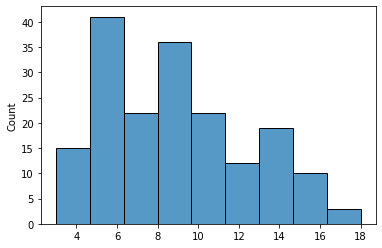

In [10]:
embedding = get_embedding(bqm, 109)
print(count_qubits_used(embedding))
sns.histplot(get_chain_lengths(bqm, embedding)[0])

In [2]:
for i in range(10, 1000):
    temp_embedding = get_embedding(bqm, i)
    print(i,count_qubits_used(temp_embedding))

NameError: name 'get_embedding' is not defined

In [1]:
from minorminer import find_clique_embedding
c_embedding = find_clique_embedding(bqm.quadratic.keys(), qpu_pegasus.edgelist())

ImportError: cannot import name 'find_clique_embedding' from 'minorminer' (/usr/local/lib/python3.9/site-packages/minorminer/__init__.py)

----------------

In [15]:
import neal

simulated_sampler = neal.SimulatedAnnealingSampler()
sampleset = simulated_sampler.sample(bqm,num_sweeps=10000000)
print(sampleset.first.energy)
get_false_clauses(sampleset.first.sample, clauses)

4.0


[[-102, -104], [-176, -179]]

In [17]:
from dwave.preprocessing.lower_bounds import roof_duality
roof_duality(bqm)

(-216.0, {})

In [39]:
sampler =  get_greedy_quantum_sampler(embedding)

In [37]:
qubit_offsets = get_0_qubits_offsets()
qpu_offsets = get_qubit_offset_ranges()
advance_annealing_of_unused(embedding, qubit_offsets)

In [48]:
for (logic_var, chain) in embedding.items():
    for c in chain:
        min_offset = get_min_offset(qpu_offsets, c)
        if logic_var <= num_variables:
            qubit_offsets[c] = min_offset/2.5
#         else:
#             divisor = 14-len(chain)+1
#             qubit_offsets[c] = min_offset/divisor

------

In [55]:
sampleset_h1 = sampler.sample(bqm, num_reads=1000,answer_mode='raw', anneal_offsets=qubit_offsets, chain_strength=1.5, auto_scale=True)
print(sampleset_h1.first.energy)
print(get_avg_energy(sampleset_h1))

26.0
33.8


In [56]:
get_false_clauses(sampleset_h1.first.sample, clauses)

[[-6, -7],
 [-31, -32],
 [-36, -37],
 [-61, -62],
 [-87, -89],
 [-106, -107],
 [-134, -135],
 [160, 131, 68, 122, 64],
 [33, 110, 133, 75, 46],
 [138, 90, 3, 11, 111],
 [65, 10, 23, 95, 154],
 [48, 5, 91, 104, 148]]

In [64]:
sampleset_offsets = sampler.sample(bqm, num_reads=1000, 
                                   anneal_schedule=[[0.0,1.0],[2.5, 0.5], [27.5,0.5],[30.0,1.0]],
                                   answer_mode='raw', 
                                   anneal_offsets=qubit_offsets, 
                                   chain_strength=1.25, 
                                   auto_scale=True, initial_state=sampleset.first.sample, 
                                   reinitialize_state=True)
print(sampleset_offsets.first.energy)
print(get_avg_energy(sampleset_offsets))

24.0
34.91
